In [2]:
import osmnx as ox
import networkx as nx
import scipy
from itertools import combinations, product

In [73]:
montreal = ox.graph_from_place("Anjou, Montreal, Canada", network_type='drive', truncate_by_edge=True)

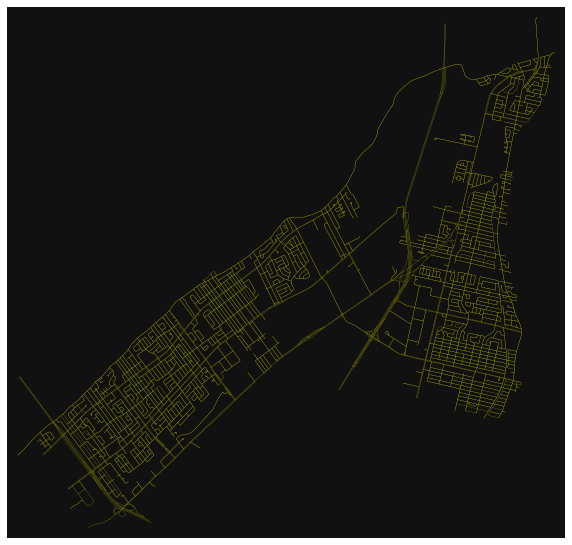

In [4]:
fig, ax = ox.plot_graph(montreal, figsize=(10, 10), node_size=0, edge_color='y', edge_linewidth=0.2)

In [74]:
montreal2 = ox.utils_graph.get_largest_component(montreal, strongly=True)
mont_proj = ox.project_graph(montreal2)
montreal3 = ox.consolidate_intersections(mont_proj, tolerance=10, rebuild_graph=True)

In [22]:
print(mont_proj.number_of_edges(),'/', mont_proj.number_of_nodes())
print(montreal3.number_of_edges(),'/', montreal3.number_of_nodes())

5456 / 1996
4708 / 1611


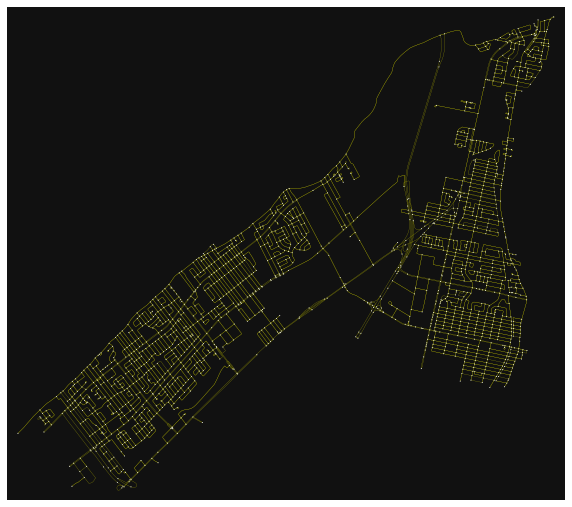

In [23]:
fig, ax = ox.plot_graph(montreal3, figsize=(10, 10), node_size=1, edge_color='y', edge_linewidth=0.2)

In [16]:
montreal4 = montreal3.to_undirected()
montreal4.number_of_edges()

2601

In [19]:
montreal4 = eulerize_weighted(montreal4)
montreal4.number_of_edges()

KeyboardInterrupt: 

In [75]:
%%time
a = eulerize_directed_weighted(montreal3)

[(7, {3: [7, 8, 23, 20, 17, 24, 15, 3]}, 3), (7, {14: [7, 8, 21, 18, 34, 39, 33, 26, 16, 14]}, 14), (7, {32: [7, 8, 23, 20, 27, 32]}, 32), (7, {38: [7, 8, 23, 20, 27, 32, 41, 38]}, 38), (7, {40: [7, 8, 23, 20, 27, 32, 41, 43, 61, 57, 75, 80, 70, 82, 60, 51, 47, 40]}, 40), (7, {63: [7, 8, 21, 18, 34, 39, 65, 36, 31, 67, 48, 63]}, 63), (7, {68: [7, 8, 23, 20, 27, 32, 41, 43, 50, 64, 68]}, 68), (7, {86: [7, 8, 23, 20, 27, 32, 41, 43, 61, 57, 55, 83, 74, 176, 86]}, 86), (7, {90: [7, 8, 21, 18, 37, 46, 42, 179, 90]}, 90), (7, {93: [7, 8, 21, 18, 34, 39, 65, 36, 31, 67, 48, 63, 52, 79, 93]}, 93)]
[(471, {431: [471, 497, 483, 478, 472, 461, 542, 437, 444, 423, 413, 453, 412, 418, 426, '445-0', 433, 431]}, 431), (471, {542: [471, 497, 483, 478, 472, 461, 542]}, 542), (499, {431: [499, 489, 502, 511, 504, 495, 505, 480, 496, 486, 485, 473, 541, 446, 482, 500, 468, 462, 540, 433, 431]}, 431), (499, {542: [499, 489, 502, 511, 504, 495, 505, 480, 496, 486, 485, 473, 541, 446, 482, 500, 458, '445-1

In [22]:
a.number_of_edges()

5115

In [26]:
montreal3.number_of_edges()

4708

In [78]:
it = nx.eulerian_circuit(a)
edgeList = []
i = 0
for edge in it:
    if i == 0:
        edgeList.append(edge[0])
    edgeList.append(edge[1])
    i += 1
len(edgeList)

1718

In [77]:
w = 0
for i in range(len(edgeList) - 1):
    w += a.edges[edgeList[i], edgeList[i + 1], 0]['length']
w

269547.9853422262

In [24]:
G_proj = ox.project_graph(montreal)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

616779735.479523

In [13]:
def eulerize_directed_weighted(G):

    nodesHigherOut = []
    nodesHigherIn = []
    for node in G.nodes():
        if (G.out_degree(node) > G.in_degree(node)):
            nodesHigherOut.append(node)
        elif (G.in_degree(node) > G.out_degree(node)):
            nodesHigherIn.append(node)

    G = nx.MultiDiGraph(G)
    if len(nodesHigherIn) == 0:
        return G

    # get all shortest paths between vertices of odd degree
    pathList = [(m,
                    {n: nx.shortest_path(G, source=m, target=n, weight='length')}, n)
                for m, n in product(nodesHigherIn, nodesHigherOut)]

    

    while nodesHigherIn != []:
        print(pathList[:10])
        # use inverse path lengths as edge-weights in a new graph
        # store the paths in the graph for easy indexing later
        Gp = nx.Graph()
        for n, Ps, lol in pathList:
            for m, P in Ps.items():
                weight = 0
                for i in range(len(P) - 1):
                    weight += G.edges[P[i], P[i + 1], 0]['length']
                if n != m:
                    Gp.add_edge(m, n, weight=1/(1 + weight), path=P)

        # find the minimum weight matching of edges in the weighted graph
        best_matching = nx.Graph(list(nx.max_weight_matching(Gp)))

        # duplicate each edge along each path in the set of paths in Gp
        for m, n in best_matching.edges():
            if not m in nodesHigherIn:
                n, m = m, n           
            path = Gp[m][n]["path"]
            G.add_edges_from(nx.utils.pairwise(path))
            if G.in_degree(n) == G.out_degree(n):
                nodesHigherOut.remove(n)
                pathList = [q for q in pathList if q[2] != n]
            if G.in_degree(m) == G.out_degree(m):
                nodesHigherIn.remove(m)
                pathList = [q for q in pathList if q[0] != m]
    return G

In [18]:
def eulerize_weighted(G):
    if G.order() == 0:
        raise nx.NetworkXPointlessConcept("Cannot Eulerize null graph")
    if not nx.is_connected(G):
        raise nx.NetworkXError("G is not connected")
    odd_degree_nodes = [n for n, d in G.degree() if d % 2 == 1]
    G = nx.MultiGraph(G)
    if len(odd_degree_nodes) == 0:
        return G

    # get all shortest paths between vertices of odd degree
    odd_deg_pairs_paths = [(m,
                            {n: nx.shortest_path(G, source=m, target=n)}
                            )
                           for m, n in combinations(odd_degree_nodes, 2)]

    # use inverse path lengths as edge-weights in a new graph
    # store the paths in the graph for easy indexing later
    Gp = nx.Graph()
    for n, Ps in odd_deg_pairs_paths:
        for m, P in Ps.items():
            weight = 0
            for i in range(len(P) - 1):
                weight += G.edges[P[i], P[i + 1], 0]['length']
            if n != m:
                Gp.add_edge(m, n, weight=1/(1 + weight), path=P)

    # find the minimum weight matching of edges in the weighted graph
    best_matching = nx.Graph(list(nx.max_weight_matching(Gp)))

    # duplicate each edge along each path in the set of paths in Gp
    for m, n in best_matching.edges():
        path = Gp[m][n]["path"]
        G.add_edges_from(nx.utils.pairwise(path))
    return G


In [124]:
#Directed
def solveNxDir(g):
    # Store nodes having incidence degree that is odd
    nodesHigherOut = []
    nodesHigherIn = []
    for node in g.nodes():
        if (g.out_degree(node) > g.in_degree(node)):
            nodesHigherOut.append(node)
        elif (g.in_degree(node) > g.out_degree(node)):
            nodesHigherIn.append(node)

    # Find shortest path between each nodes

    shortPathList = []

    for src in nodesHigherIn:
        for dst in nodesHigherOut:
            dist, path = nx.single_source_dijkstra(g, src, dst, weight='length')
            elm = (path, -dist)
            shortPathList.append(elm)


    

    print("SHORTEST PATH FINISHED")
    # Make a graph of the odd nodes that links the nodes  by their shortest path
    #   each edge will have the shortest path as weight

    while len(nodesHigherIn) > 0:

        
        nG = nx.Graph()

        edgeToPath = {}

        for path in shortPathList:
            edge = (path[0][0], path[0][-1])
            edgeToPath[edge] = path[0]
            nG.add_edge(edge[0], edge[1], weight=path[1])


        # Do the MINIMAL matching weighted matching

        matching = nx.max_weight_matching(nG, weight='length')

        print("Matching FINISHED")

        # We have all the edges that represent the minimum paths

        print(matching)

        for edge in matching:
            if edge not in edgeToPath:
                continue
            path = edgeToPath[edge]
            for i in range(len(path) - 1):
                src = path[i]
                dst = path[i + 1]
                weight = g.edges[src, dst, 0]['length']
                g.add_edge(src, dst, length=weight)

            dst = path[-1]
            src = path[0]
            if g.in_degree(dst) == g.out_degree(dst):
                nodesHigherOut.remove(dst)
                shortPathList = [pathtis for pathtis in shortPathList if pathtis[0][-1] != dst]
            if g.in_degree(src) == g.out_degree(src):
                nodesHigherIn.remove(src)
                shortPathList = [pathtis for pathtis in shortPathList if pathtis[0][0] != src]
    
    # Find all paths using edges to add to the original graph for it to be an eulerian cycle
    
    it = nx.eulerian_circuit(g)
    edgeList = []
    i = 0
    for edge in it:
        if i == 0:
            edgeList.append(edge[0])
        edgeList.append(edge[1])
        i += 1
    return edgeList

In [139]:
# Undirected = MultiGraph
def solveNx(g):

    # Copy graph to not alter original graph

    G = nx.MultiGraph(g)

    # Store nodes having incidence degree that is odd

    nodesDegOdd = [n for n, d in G.degree() if d % 2 == 1]
    
    # Find shortest path between each nodes
    
    shortPathList = []
    
    for i in range(len(nodesDegOdd)):
        u = nodesDegOdd[i]
        for v in nodesDegOdd[i:]:
            dist, path = nx.single_source_dijkstra(G, u, v, weight='length')
            elm = (path, dist)
            shortPathList.append(elm)
            
    
    # Make a graph of the odd nodes that links the nodes  by their shortest path
    #   each edge will have the shortest path as weight
    
    nG = nx.Graph()

    edgeToPath = {}

    for path in shortPathList:
        edge = (path[0][0], path[0][-1])
        otherEdge = (path[0][-1], path[0][0])
        edgeToPath[edge] = path[0]
        edgeToPath[otherEdge] = path[0]
        nG.add_edge(edge[0], edge[1], weight= 1 / (1 + path[1]))
    
    # Do the MINIMAL matching weighted matching
    
    matching = nx.max_weight_matching(nG, weight='length')
    
    # We have all the edges that represent the minimum paths
    
    for edge in matching:
        path = edgeToPath[edge]
        for i in range(len(path) - 1):
            src = path[i]
            dst = path[i + 1]
            weight = G.edges[src, dst, 0]['length']
            G.add_edge(src, dst, length=weight)
    
    # Find all paths using edges to add to the original graph for it to be an eulerian cycle
    
    it = nx.eulerian_circuit(G)
    edgeList = []
    for edge in it:
        edgeList.append(edge)
    return edgeList, G

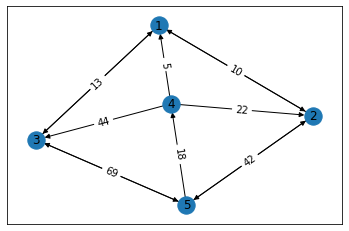

In [105]:
def print_GRF(G):
    lol = nx.Graph(G)

    pos = nx.spring_layout(G)

    nx.draw_networkx(G, pos)
    labels = nx.get_edge_attributes(lol,'length')
    a = nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

dirg = nx.MultiDiGraph()
dirg.add_edge(1, 2, length=10)
dirg.add_edge(2,1, length=12)
dirg.add_edge(1,3, length=13)
dirg.add_edge(3, 1, length=33)
dirg.add_edge(4, 1, length=5)
dirg.add_edge(4, 2, length=22)
dirg.add_edge(4, 3, length=44)
dirg.add_edge(5, 2, length=57)
dirg.add_edge(2, 5, length=42)
dirg.add_edge(5, 3, length=88)
dirg.add_edge(3, 5, length=69)
dirg.add_edge(5, 4, length=18)
print_GRF(dirg)

In [103]:
%%time
old_edges = montreal3.number_of_edges()
route = solveNxDir(montreal3)
new_edges = montreal3.number_of_edges()
print("We added", new_edges - old_edges, "edges")

 132, 140, 158, 167, 179, 196, 222, 230, 231, 238, 246, 262, 271, 279, 295, 303, 315, 323, 332, 341, 342, 346, 364, 373, 377, 381, 389, 390, 396, 397, 398, 399, 406, 407, 410, 411, '163-0', '163-1', '304-0', '40-0'] [3, 4, 16, 27, 32, 33, 41, 42, 52, 53, 56, 58, 64, 65, 72, 73, 76, 81, 88, 91, 101, 104, 120, 123, 125, 128, 141, 154, 160, 170, 178, 186, 188, 203, 220, 226, 256, 266, 280, 281, 291, 292, 298, 302, 310, 322, 330, 337, 345, 347, 354, 357, 360, 372, 378, 380, 386, '175-0', '40-1']
Matching FINISHED
[5, 22, 31, 36, 38, 39, 55, 60, 61, 71, 78, 86, 95, 102, 110, 115, 119, 127, 132, 140, 158, 167, 179, 196, 222, 230, 231, 238, 246, 262, 271, 279, 295, 303, 315, 323, 332, 341, 342, 346, 364, 373, 377, 381, 389, 390, 396, 397, 398, 399, 406, 407, 410, 411, '163-0', '163-1', '304-0', '40-0'] [3, 4, 16, 27, 32, 33, 41, 42, 52, 53, 56, 58, 64, 65, 72, 73, 76, 81, 88, 91, 101, 104, 120, 123, 125, 128, 141, 154, 160, 170, 178, 186, 188, 203, 220, 226, 256, 266, 280, 281, 291, 292, 298,

KeyboardInterrupt: 

In [106]:
route = solveNxDir(dirg)

SHORTEST PATH FINISHED
Matching FINISHED
{(2, 5), (3, 4)}
Matching FINISHED
{(1, 4)}


[1, 2, 5, 3, 5, 4, 3, 5, 2, 5, 4, 2, 5, 4, 1, 3, 1, 2, 1]

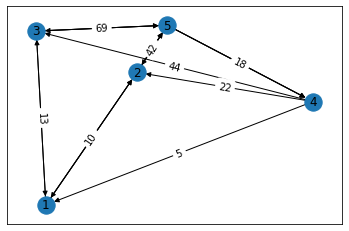

In [295]:
print_GRF(dirg)
dirg.edges()
route

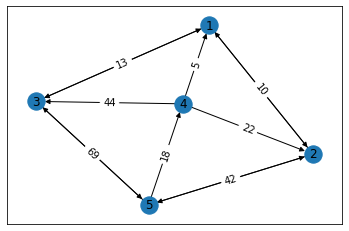

In [32]:
def print_GRF(G):
    lol = nx.Graph(G)

    pos = nx.spring_layout(G)

    nx.draw_networkx(G, pos)
    labels = nx.get_edge_attributes(lol,'length')
    a = nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

dirg = nx.MultiDiGraph()
dirg.add_edge(1, 2, length=10)
dirg.add_edge(2,1, length=12)
dirg.add_edge(1,3, length=13)
dirg.add_edge(3, 1, length=33)
dirg.add_edge(4, 1, length=5)
dirg.add_edge(4, 2, length=22)
dirg.add_edge(4, 3, length=44)
dirg.add_edge(5, 2, length=57)
dirg.add_edge(2, 5, length=42)
dirg.add_edge(5, 3, length=88)
dirg.add_edge(3, 5, length=69)
dirg.add_edge(5, 4, length=18)
print_GRF(dirg)

In [18]:
print(montreal3.number_of_edges())
new_edges

984


3233

In [176]:
print(route[45])
nx.shortest_path(montreal3, 0, 8, weight='length')

135


[0, 5, 8]

In [9]:
ox.folium.plot_graph_folium(montreal, edge_width=2)

In [31]:
# print_GRF(montreal3)

from IPython.display import clear_output
for i in range(1, len(edgeList) - 1):
    clear_output(wait=True)
    ox.plot_graph_route(montreal3, edgeList[:i], figsize=(15, 15), node_size=1, edge_color='y', edge_linewidth=0.1, route_alpha=0.3)

KeyboardInterrupt: 

In [76]:
# show some basic stats about the network
ox.basic_stats(montreal2, clean_intersects=True, circuity_dist='euclidean')

KeyError: 'length'

In [3]:
import networkx as nx

In [23]:
nodes, edges = ox.graph_to_gdfs(montreal3)

In [208]:
nx.dijkstra_path_length(montreal3, route[44], route[50], weight='length')

0

In [27]:
montreal3.nodes[0]['lon']

-73.5965221

In [45]:
UG = ox.graph_from_gdfs(nodes, edges)

In [33]:
  # Download graph of district from OSM
graph = ox.graph_from_place("Anjou" + ", Montreal, Canada",
                            network_type='drive', truncate_by_edge=True)

# Get largest component so that the graph is strongly connected
graph = ox.utils_graph.get_largest_component(graph, strongly=True)

# Project the graph and merge intersections that are close to better analyze
g_proj = ox.project_graph(graph)

# Transform the graph into an eulerian graph

result = eulerize_directed_weighted(graph_cons)

# Find an eulerian circuit, and build the list of tuples 'latitude',
#                                                        'longitude'

it = nx.eulerian_circuit(result)
coordList = []
i = 0
for edge in it:
    print(edge)
    # if i == 0:
    #     coordList.append((graph_cons.nodes[edge[0]]['lat'],
    #                     graph_cons.nodes[edge[0]]['lon']))
    # coordList.append((graph_cons.nodes[edge[1]]['lat'],
    #                 graph_cons.nodes[edge[1]]['lon']))
    i += 1

[(7, {3: [7, 8, 23, 20, 17, 24, 15, 3]}, 3), (7, {14: [7, 8, 21, 18, 34, 39, 33, 26, 16, 14]}, 14), (7, {32: [7, 8, 23, 20, 27, 32]}, 32), (7, {38: [7, 8, 23, 20, 27, 32, 41, 38]}, 38), (7, {40: [7, 8, 23, 20, 27, 32, 41, 43, 61, 57, 75, 80, 70, 82, 60, 51, 47, 40]}, 40), (7, {63: [7, 8, 21, 18, 34, 39, 65, 36, 31, 67, 48, 63]}, 63), (7, {68: [7, 8, 23, 20, 27, 32, 41, 43, 50, 64, 68]}, 68), (7, {86: [7, 8, 23, 20, 27, 32, 41, 43, 61, 57, 55, 83, 74, 176, 86]}, 86), (7, {90: [7, 8, 21, 18, 37, 46, 42, 179, 90]}, 90), (7, {93: [7, 8, 21, 18, 34, 39, 65, 36, 31, 67, 48, 63, 52, 79, 93]}, 93)]
[(471, {431: [471, 497, 483, 478, 472, 461, 542, 437, 444, 423, 413, 453, 412, 418, 426, '445-0', 433, 431]}, 431), (471, {542: [471, 497, 483, 478, 472, 461, 542]}, 542), (499, {431: [499, 489, 502, 511, 504, 495, 505, 480, 496, 486, 485, 473, 541, 446, 482, 500, 468, 462, 540, 433, 431]}, 431), (499, {542: [499, 489, 502, 511, 504, 495, 505, 480, 496, 486, 485, 473, 541, 446, 482, 500, 458, '445-1

In [70]:
nodes, edges = ox.graph_to_gdfs(g_proj)

In [72]:
nodes.count()

y           757
x           757
osmid       757
lon         757
lat         757
highway      72
ref          10
geometry    757
dtype: int64

In [64]:
len

5


558

In [60]:
edges

osmid                            name  \
0                              22909983                 Avenue du Layon   
1                              22909977                Avenue du Bocage   
2                [288388570, 459818082]  Boulevard des Galeries-d'Anjou   
3                              22909977                Avenue du Bocage   
4                              22909975             Avenue des Jalesnes   
...                                 ...                             ...   
1423  [115758944, 110740985, 476892434]              Boulevard Roi-René   
1424                          285089357  Boulevard des Galeries-d'Anjou   
1425                          521502904               Avenue de Belfroy   
1426                           22915781               Rue de la Pléiade   
1427  [284915251, 284915253, 471504958]  Boulevard des Galeries-d'Anjou   

          highway  oneway      length  \
0     residential   False  138.796718   
1     residential   False  237.328000   
2        tertiary    True  122.803469   
3     residential   False   65.354000   
4     residential   False  201.449000   
...           ...     ...         ...   
1423     tertiary    True  163.427893   
1424     tertiary    True  250.332617   
1425  residential   False   67.385000   
1426  residential   False  233.461000   
1427     tertiary    True  348.647843   

                                               geometry  u_original  \
0     LINESTRING (613095.546 5049628.005, 613150.117...   246653593   
1     LINESTRING (613095.546 5049628.005, 613043.343...   246653593   
2     LINESTRING (613242.413 5049675.050, 613226.285...  1260357765   
3     LINESTRING (612843.102 5049743.860, 612870.935...   246653587   
4     LINESTRING (612843.102 5049743.860, 612957.738...   246653587   
...                                                 ...         ...   
1423  LINESTRING (612328.738 5052175.210, 612341.165...   224911595   
1424  LINESTRING (611312.698 5050688.787, 611100.800...   596687338   
1425  LINESTRING (611312.698 5050688.787, 611346.168...   596687338   
1426  LINESTRING (611306.648 5050678.477, 611280.916...   596687339   
1427  LINESTRING (611306.648 5050678.477, 611376.401...   596687339   

      v_original lanes maxspeed   bridge  ref access      u    v  key  
0     2886138592   NaN      NaN      NaN  NaN    NaN      0    5    0  
1      246653584   NaN      NaN      NaN  NaN    NaN      0   12    0  
2      246653399   NaN      NaN      NaN  NaN    NaN      1    5    0  
3      246653588   NaN      NaN      NaN  NaN    NaN      2   11    0  
4      246653589   NaN      NaN      NaN  NaN    NaN      2    4    0  
...          ...   ...      ...      ...  ...    ...    ...  ...  ...  
1423   622793732     2       50      yes  NaN    NaN  445-1  418    0  
1424   596687346     2      NaN      NaN  NaN    NaN   98-0  120    0  
1425   246713748   NaN      NaN      NaN  NaN    NaN   98-0  128    0  
1426   246713745   NaN      NaN      NaN  NaN    NaN   98-1   73    0  
1427  3212402316     2      NaN  viaduct  NaN    NaN   98-1   72    0  

[1428 rows x 16 columns]